In [61]:
%load_ext autoreload
%autoreload 2

import torch
from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.artifacts.texture_artifact import TextureArtifact

torch.set_grad_enabled(False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
from text3d2video.pipelines.generative_rendering_pipeline import GenerativeRenderingPipeline
from text3d2video.pipelines.pipeline_utils import load_pipeline

pipe = load_pipeline(GenerativeRenderingPipeline)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [63]:
tex_tag = "human_mvlatest_Deadpool:latest"
tex_tag = "human_mvlatest_Stormtrooper:latest"
tex_tag = 'cat_statue_mvlatest_SilverCatStatue:latest'

texture_art = TextureArtifact.from_wandb_artifact_tag(tex_tag)
texture = texture_art.read_texture()

anim_tag = 'catwalk_180_20:latest'
anim_tag = 'mma_20:latest'
anim_tag = 'ymca_20:latest'
anim_tag = 'mv_cat_statue:latest'
anim_tag = 'mv_cat_statue_25:latest'

anim_art = AnimationArtifact.from_wandb_artifact_tag(anim_tag)
anim = anim_art.read_anim_seq()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb:   4 of 4 files downloaded.  


In [64]:
from text3d2video.rendering import render_texture
from text3d2video.utilities.video_comparison import display_vids
from text3d2video.utilities.video_util import pil_frames_to_clip

anim_uvs = anim.render_rgb_uv_maps()
anim_renders = render_texture(
    anim.meshes, anim.cams, texture, anim.verts_uvs, anim.faces_uvs, return_pil=True
)
display_vids([pil_frames_to_clip(anim_renders), pil_frames_to_clip(anim_uvs)])

In [66]:
from text3d2video.artifacts.anim_artifact import AnimSequence
from text3d2video.util import ordered_sample_indices

# extr_indices = [0]
src_indices = [0, 7]
src_indices = [-1]
src_indices = ordered_sample_indices(anim_renders, 5).tolist()
# src_indices = [0, 2, 4, 6]

src_anim = AnimSequence(
    cams=anim.cams[src_indices],
    meshes=anim.meshes[src_indices],
    verts_uvs=anim.verts_uvs,
    faces_uvs=anim.faces_uvs,
)

In [8]:
src_tag = 'human_mv:latest'

src_anim_art = AnimationArtifact.from_wandb_artifact_tag(src_tag)
src_anim = src_anim_art.read_anim_seq(src_anim_art.frame_indices(5))

In [9]:
from torch import Tensor
from pytorch3d.structures.meshes import join_meshes_as_batch
from pytorch3d.renderer.camera_utils import join_cameras_as_batch

mesh = anim.meshes[-1]
cam = anim.cams[-1]

offsets = Tensor([[0, 0.0, 0], [0, 0.3, 0], [0, 0.6, 0], [0, 0.9, 0]]).cuda()

cams = []
for o in offsets:
    shifted = cam.clone()
    shifted.T = shifted.T + o
    cams.append(shifted)

cams = join_cameras_as_batch(cams)
meshes = join_meshes_as_batch([mesh] * len(offsets))

src_anim = AnimSequence(
    cams=cams,
    meshes=meshes,
    verts_uvs=anim.verts_uvs,
    faces_uvs=anim.faces_uvs,
)

In [67]:
from text3d2video.utilities.video_comparison import display_vid

src_vid = pil_frames_to_clip(src_anim.render_rgb_uv_maps(), fps=1.5)
display_vid(src_vid, title="src")

In [88]:
from pathlib import Path
from torch import Generator
from text3d2video.pipelines.generative_rendering_pipeline import (
    GenerativeRenderingConfig,
)
from text3d2video.utilities.logging import H5Logger

module_paths = [
    "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

extraction_modules = [module_paths[-1]]

gr_config = GenerativeRenderingConfig(
    module_paths=module_paths,
    num_inference_steps=15,
    do_pre_attn_injection=True,
    do_post_attn_injection=True,
    num_keyframes=5,
    attend_to_self_kv=True
)

torch.cuda.empty_cache()

generator = Generator(device="cuda").manual_seed(1)
kf_generator = Generator(device="cuda").manual_seed(1)

logger = H5Logger(Path("data.h5"), enabled=False)
logger.delete_data()
logger.open_write()

logger.key_greenlists["layer"] = extraction_modules

start_noise_level = 0.0

input_src_anim = src_anim
input_src_anim = None

input_texture = texture
input_texture = None

out = pipe(
    "Metalic Cat Statue",
    anim,
    gr_config,
    src_anim=input_src_anim,
    start_noise_level=start_noise_level,
    texture=input_texture,
    logger=logger,
    kf_generator=kf_generator,
    generator=generator,
)

logger.close()

  0%|          | 0/15 [00:00<?, ?it/s]

1.0


  7%|▋         | 1/15 [00:03<00:43,  3.12s/it]

0.95


 13%|█▎        | 2/15 [00:06<00:41,  3.20s/it]

0.9


 20%|██        | 3/15 [00:09<00:38,  3.23s/it]

0.85


 27%|██▋       | 4/15 [00:12<00:35,  3.23s/it]

0.8


 33%|███▎      | 5/15 [00:16<00:32,  3.24s/it]

0.75


 40%|████      | 6/15 [00:19<00:29,  3.24s/it]

0.7


 47%|████▋     | 7/15 [00:22<00:25,  3.24s/it]

0.65


 53%|█████▎    | 8/15 [00:25<00:22,  3.24s/it]

0.6000000000000001


 60%|██████    | 9/15 [00:29<00:19,  3.24s/it]

0.55


 67%|██████▋   | 10/15 [00:32<00:16,  3.24s/it]

0.5


 73%|███████▎  | 11/15 [00:35<00:12,  3.24s/it]

0.45000000000000007


 80%|████████  | 12/15 [00:38<00:09,  3.24s/it]

0.4


 87%|████████▋ | 13/15 [00:42<00:06,  3.24s/it]

0.35


 93%|█████████▎| 14/15 [00:45<00:03,  3.24s/it]

0.30000000000000004


100%|██████████| 15/15 [00:48<00:00,  3.24s/it]


In [89]:
vids = [pil_frames_to_clip(out.images)]

title = "Video"
if input_texture is not None:
    title += f" (from_noise {start_noise_level})"

titles = [title]

if out.extr_images is not None:
    extr_vid = pil_frames_to_clip(out.extr_images, fps=2)
    vids.append(extr_vid)
    titles.append("Extraction Images")

# prepend vid
if input_texture is not None:
    vids = [pil_frames_to_clip(anim_renders)] + vids
    titles = ["Renders"] + titles

display_vids(vids, titles=titles)

In [87]:
from text3d2video.backprojection import compute_texel_projections, project_views_to_video_texture
import torchvision.transforms.functional as TF

texture_res = 600
projections = compute_texel_projections(
    anim.meshes, anim.cams, anim.verts_uvs, anim.faces_uvs, texture_res=texture_res
)

images_pt = torch.stack([TF.to_tensor(x) for x in out.images]).cuda()
frames_uv = project_views_to_video_texture(images_pt, texture_res, projections).cpu()
frames_uv_pil = [TF.to_pil_image(x) for x in frames_uv]
uv_vid = pil_frames_to_clip(frames_uv_pil)

video = pil_frames_to_clip(out.images)

display_vids([video, uv_vid], titles=["Video", "UV Video"])

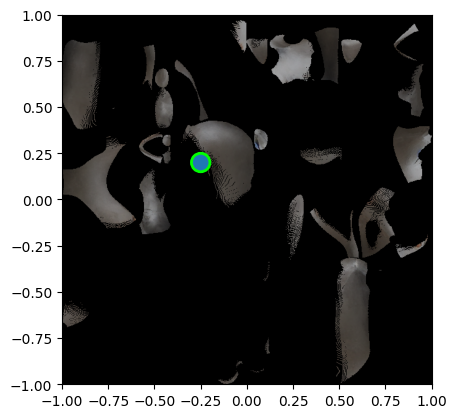

In [77]:
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

coord = Tensor([-0.25, 0.2])
frame = frames_uv[0]

frame_pil = TF.to_pil_image(frame.cpu())

fig, ax = plt.subplots(1)
ax.imshow(frame_pil, extent=[-1, 1, -1, 1])
circle = Circle(coord, radius=0.05, linewidth=2, edgecolor="lime")
ax.add_patch(circle)

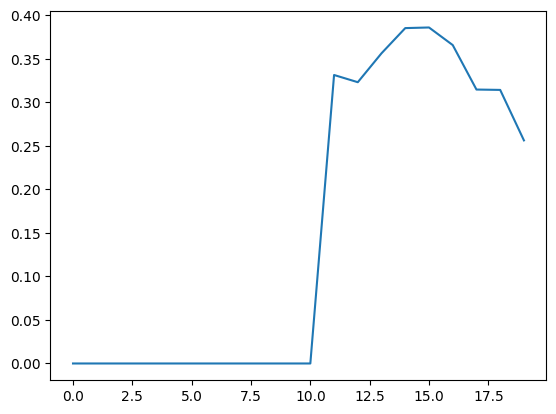

In [78]:
from text3d2video.util import rgb_to_luminance, sample_feature_map_ndc

colors = torch.stack(
    [sample_feature_map_ndc(x, coord.unsqueeze(0))[0] for x in frames_uv]
)
luminances = [rgb_to_luminance(c[0], c[1], c[2]) for c in colors]

plt.plot(luminances)